In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%config Completer.use_jedi = False

In [4]:
import sys, os, pickle, time, warnings, h5py

import numpy as np, pandas as pd, scipy, scipy.stats as stats, tqdm, h5py, emcee
from copy import deepcopy as copy

sys.path.extend(['../utilities/', '../models/'])
import samplers, disk_cone_plcut as dcp, plotting, transformations
import disk_halo_mstogap as dh_msto
from transformations import func_inv_jac, func_labels, label_dict
import sf_utils

from multiprocessing import Pool

In [5]:
# Plotting modules
import matplotlib
from pylab import cm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', labelsize=16)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('legend',fontsize=16)
plt.rc('font',size=16)
from pylab import Rectangle

In [6]:
from selectionfunctions.config import config
config['data_dir'] = '/data/asfe2/Projects/testselectionfunctions/'

In [8]:
print('G amplitude...')
# Model for G error
data={}
with h5py.File('/home/andy/Documents/Projects/GitRepos/selectionfunctions/selectionfunctions/examples/FIRE/median_gamp_edr3.h', 'r') as hf:
    data['magbin'] = hf['magbin'][...]+0.05
    data['med_gamp'] = hf['med_gamp'][...]

G amplitude...


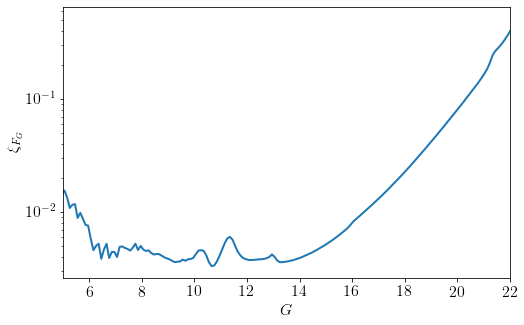

In [16]:
plt.figure(figsize=(8,5))

plt.plot(data['magbin'], data['med_gamp'], linewidth=2)
plt.yscale('log')
plt.xlim(5,22)

plt.xlabel(r'$G$')
plt.ylabel(r'$\xi_{F_G}$')

plt.savefig('figs/g_flux_error_amp.png', bbox_inches='tight', facecolor='w')

In [18]:
import sys, pickle
sys.path.append('/home/andy/Documents/Research/software/')
import sqlutilpy, getdata, numpy as np, h5py

## Running median

In [52]:
catalogue = "gaia_edr3.gaia_source"
#catalogue = "andy_everall.gaia3_rand100m"
query = f"""select floor(phot_g_mean_mag/0.1)*0.1 as magbin,
                    percentile_cont(0.5) within group (ORDER BY SQRT(phot_g_n_obs)*phot_g_mean_flux_error/phot_g_mean_flux) as gamp_50,
                    percentile_cont(0.16) within group (ORDER BY SQRT(phot_g_n_obs)*phot_g_mean_flux_error/phot_g_mean_flux) as gamp_16,
                    percentile_cont(0.84) within group (ORDER BY SQRT(phot_g_n_obs)*phot_g_mean_flux_error/phot_g_mean_flux) as gamp_84
                    from {catalogue}
                    where phot_g_mean_mag is not NULL
                    group by magbin"""
print(query)
%time med_amp = sqlutilpy.get(query, asDict=True, **getdata.sql_args)

select floor(phot_g_mean_mag/0.1)*0.1 as magbin,
                    percentile_cont(0.5) within group (ORDER BY SQRT(phot_g_n_obs)*phot_g_mean_flux_error/phot_g_mean_flux) as gamp_50,
                    percentile_cont(0.16) within group (ORDER BY SQRT(phot_g_n_obs)*phot_g_mean_flux_error/phot_g_mean_flux) as gamp_16,
                    percentile_cont(0.84) within group (ORDER BY SQRT(phot_g_n_obs)*phot_g_mean_flux_error/phot_g_mean_flux) as gamp_84
                    from gaia_edr3.gaia_source
                    where phot_g_mean_mag is not NULL
                    group by magbin
CPU times: user 164 ms, sys: 40 ms, total: 204 ms
Wall time: 46min 26s


In [53]:
print('Processing data')
order = np.argsort(med_amp['magbin'])
for key in med_amp.keys():
    med_amp[key] = med_amp[key][order]

Processing data


Text(0, 0.5, '$\\xi_{F_G}$')

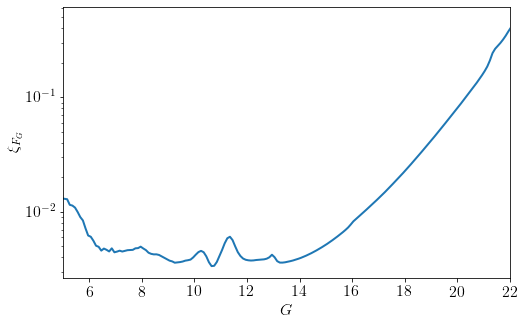

In [54]:
plt.figure(figsize=(8,5))

plt.plot(med_amp['magbin']+0.05, med_amp['gamp_50'], linewidth=2)
plt.yscale('log')
plt.xlim(5,22)

plt.xlabel(r'$G$')
plt.ylabel(r'$\xi_{F_G}$')

# plt.savefig('figs/g_flux_error_amp.png', bbox_inches='tight', facecolor='w')

## Histogram

In [55]:
catalogue = "gaia_edr3.gaia_source"
#catalogue = "andy_everall.gaia3_rand100m"
query = f"""select floor(phot_g_mean_mag/0.1)*0.1 as magbin,
                   floor(LOG( SQRT(phot_g_n_obs)*phot_g_mean_flux_error/phot_g_mean_flux )/0.02 )*0.02 as gamp,
                   count(*)
                    from {catalogue}
                    where phot_g_mean_mag is not NULL
                    group by magbin, gamp"""
print(query)
%time hist = sqlutilpy.get(query, asDict=True, **getdata.sql_args)

select floor(phot_g_mean_mag/0.1)*0.1 as magbin,
                   floor(LOG( SQRT(phot_g_n_obs)*phot_g_mean_flux_error/phot_g_mean_flux )/0.02 )*0.02 as gamp,
                   count(*)
                    from gaia_edr3.gaia_source
                    where phot_g_mean_mag is not NULL
                    group by magbin, gamp
CPU times: user 184 ms, sys: 56 ms, total: 240 ms
Wall time: 47min 31s


In [56]:
mag_w = 0.1; gamp_w=0.02
mag_rng = [5.,22.]
gamp_rng = [-3,0]
grid = np.zeros((int((mag_rng[1]-mag_rng[0])/mag_w+0.1), int((gamp_rng[1]-gamp_rng[0])/gamp_w+0.1)), dtype=int)

in_rng = (hist['magbin']>mag_rng[0]-1e-10)&(hist['magbin']<mag_rng[1])&\
         (hist['gamp']>gamp_rng[0]-1e-10)&(hist['gamp']<gamp_rng[1])

grid[((hist['magbin']-mag_rng[0])/mag_w + 0.1).astype(int)[in_rng],
     ((hist['gamp']-gamp_rng[0])/gamp_w + 0.1).astype(int)[in_rng]]=hist['count'][in_rng]

/home/andy/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """Entry point for launching an IPython kernel.


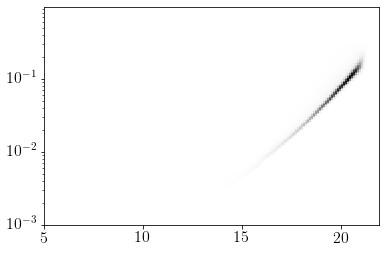

In [57]:
plt.pcolor(np.arange(*mag_rng, mag_w), 10**np.arange(*gamp_rng, gamp_w), grid.T, cmap='Greys')
plt.yscale('log')

In [41]:
np.unique(hist['magbin'])

array([ 1.7,  2.1,  2.3,  2.4,  2.5,  2.6,  2.7,  2.9,  3. ,  3.2,  3.4,
        3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,  4.4,  4.5,
        4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,  5.5,  5.6,
        5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,  6.6,  6.7,
        6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,  7.7,  7.8,
        7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,  8.8,  8.9,
        9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,  9.9, 10. ,
       10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9, 11. , 11.1,
       11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12. , 12.1, 12.2,
       12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13. , 13.1, 13.2, 13.3,
       13.4, 13.5, 13.6, 13.7, 13.8, 13.9, 14. , 14.1, 14.2, 14.3, 14.4,
       14.5, 14.6, 14.7, 14.8, 14.9, 15. , 15.1, 15.2, 15.3, 15.4, 15.5,
       15.6, 15.7, 15.8, 15.9, 16. , 16.1, 16.2, 16.3, 16.4, 16.5, 16.6,
       16.7, 16.8, 16.9, 17. , 17.1, 17.2, 17.3, 17

In [46]:
np.arange(mag_rng, mag_rng[1]+1e-10, mag_w)

array([ 5. ,  5.1,  5.2,  5.3,  5.4,  5.5,  5.6,  5.7,  5.8,  5.9,  6. ,
        6.1,  6.2,  6.3,  6.4,  6.5,  6.6,  6.7,  6.8,  6.9,  7. ,  7.1,
        7.2,  7.3,  7.4,  7.5,  7.6,  7.7,  7.8,  7.9,  8. ,  8.1,  8.2,
        8.3,  8.4,  8.5,  8.6,  8.7,  8.8,  8.9,  9. ,  9.1,  9.2,  9.3,
        9.4,  9.5,  9.6,  9.7,  9.8,  9.9, 10. , 10.1, 10.2, 10.3, 10.4,
       10.5, 10.6, 10.7, 10.8, 10.9, 11. , 11.1, 11.2, 11.3, 11.4, 11.5,
       11.6, 11.7, 11.8, 11.9, 12. , 12.1, 12.2, 12.3, 12.4, 12.5, 12.6,
       12.7, 12.8, 12.9, 13. , 13.1, 13.2, 13.3, 13.4, 13.5, 13.6, 13.7,
       13.8, 13.9, 14. , 14.1, 14.2, 14.3, 14.4, 14.5, 14.6, 14.7, 14.8,
       14.9, 15. , 15.1, 15.2, 15.3, 15.4, 15.5, 15.6, 15.7, 15.8, 15.9,
       16. , 16.1, 16.2, 16.3, 16.4, 16.5, 16.6, 16.7, 16.8, 16.9, 17. ,
       17.1, 17.2, 17.3, 17.4, 17.5, 17.6, 17.7, 17.8, 17.9, 18. , 18.1,
       18.2, 18.3, 18.4, 18.5, 18.6, 18.7, 18.8, 18.9, 19. , 19.1, 19.2,
       19.3, 19.4, 19.5, 19.6, 19.7, 19.8, 19.9, 20

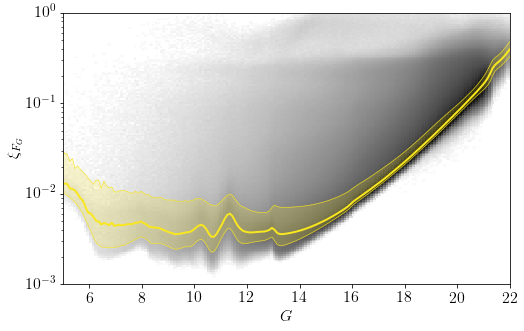

In [77]:
plt.figure(figsize=(8,5))

plt.pcolor(np.arange(mag_rng[0], mag_rng[1]+1e-10, mag_w), 
           10**np.arange(gamp_rng[0], gamp_rng[1]+1e-10, gamp_w), grid.T, cmap='Greys', norm=LogNorm())

plt.plot(med_amp['magbin']+0.05, med_amp['gamp_50'], linewidth=2, color=cm.viridis(0.99))
plt.fill_between(med_amp['magbin']+0.05, med_amp['gamp_16'], 
                                         med_amp['gamp_84'], alpha=0.2, color=cm.viridis(0.99))
plt.plot(med_amp['magbin']+0.05, med_amp['gamp_16'], linewidth=0.5, color=cm.viridis(0.99))
plt.plot(med_amp['magbin']+0.05, med_amp['gamp_84'], linewidth=0.5, color=cm.viridis(0.99))
plt.yscale('log')
plt.xlim(5,22)

plt.xlabel(r'$G$')
plt.ylabel(r'$\xi_{F_G}$')

plt.savefig('figs/g_flux_error_amp.png', bbox_inches='tight', facecolor='w')

In [63]:
savefile = 'median_gamp_edr3.h'
print(f'Saving data: {savefile}')
with h5py.File(savefile, 'w') as hf:
    for key in med_amp.keys():
        hf.create_dataset(os.path.join('median',key), data=med_amp[key])
    for key in hist.keys():
        hf.create_dataset(os.path.join('hist',key), data=hist[key])

Saving data: median_gamp_edr3.h
